
# 논문 통계 분석 ipynb 템플릿 (쉬운 설명 버전)
작성일: 2025-09-29 15:09

이 노트북은 **연구 가설 → 데이터 불러오기 → 정리(결측치) → 기초분석 → 가설검정 → 회귀모형 → 효과크기 → 검정력(power) → 결과표 저장** 순서로 진행합니다.

실습 데이터: `example_data_ko.csv` (가짜 데이터)
- 열 설명:  
  - `sex`: 성별(F/M)  
  - `group`: 집단(control/treat)  
  - `age`: 나이  
  - `pre`: 사전 점수  
  - `post`: 사후 점수  
  - `passed`: 합격 여부(0/1)


## 0. 준비하기(재현성 설정)

In [20]:

# 이 셀은 결과를 다시 실행해도 비슷한 값이 나오게 해줍니다.
import numpy as np, pandas as pd
np.random.seed(7)  # 숫자를 바꾸면 무작위 값이 달라집니다.
pd.set_option('display.max_columns', 50)


## 1. 연구 질문과 가설 정리


- 연구 질문(RQ): **처치 집단(treat)은 통제 집단(control)보다 사후 점수(post)가 높은가?**
- 귀무가설(H0): 두 집단의 평균 사후 점수는 **차이가 없다**.
- 대립가설(H1): 두 집단의 평균 사후 점수는 **차이가 있다**.  
- 유의수준(α): 0.05


## 2. 데이터 불러오기와 첫 확인

In [21]:

# CSV 파일을 불러옵니다.
import pandas as pd
df = pd.read_csv("example_data_ko.csv")
# 앞부분 5행만 간단히 봅니다.
df.head()


,sex,group,age,pre,post,passed
0,F,treat,28.9,47.8,57.0,0
1,M,control,23.8,42.5,52.4,0
2,F,treat,29.3,75.2,77.9,1
3,M,control,30.7,57.6,66.4,0
4,M,control,24.4,50.1,57.0,0


In [22]:

# 데이터 구조(열 이름, 자료형, 결측치 개요)를 확인합니다.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     240 non-null    object 
 1   group   240 non-null    object 
 2   age     230 non-null    float64
 3   pre     231 non-null    float64
 4   post    232 non-null    float64
 5   passed  240 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


## 3. 결측치(빈칸) 확인과 처리 계획

In [23]:

# 각 열별 결측치 비율을 확인합니다.
df.isna().mean().to_frame('missing_rate')


,missing_rate
sex,0.000000
group,0.000000
age,0.041667
pre,0.037500
post,0.033333
passed,0.000000


In [24]:

# 간단한 처리 방법: 숫자열은 평균으로, 문자/범주형은 가장 많이 나온 값으로 채우기
from sklearn.impute import SimpleImputer

num_cols = ['age','pre','post']   # 숫자열 목록
cat_cols = ['sex','group']        # 범주형(문자) 열 목록

num_imp = SimpleImputer(strategy='mean')            # 평균 대체
cat_imp = SimpleImputer(strategy='most_frequent')   # 최빈값 대체

df_imp = df.copy()
df_imp[num_cols] = num_imp.fit_transform(df_imp[num_cols])
df_imp[cat_cols] = cat_imp.fit_transform(df_imp[cat_cols])

# 결측치가 잘 채워졌는지 다시 확인
df_imp.isna().sum().to_frame('n_missing_after_impute')


,n_missing_after_impute
sex,0
group,0
age,0
pre,0
post,0
passed,0


## 4. 기초 통계와 간단 시각화

In [25]:

# 숫자열의 평균, 표준편차 등 기본 통계를 봅니다.
df_imp.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sex,240,2,F,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group,240,2,control,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,240.0,NaN,NaN,NaN,26.344783,4.168556,13.9,23.8,26.344783,29.025,38.8
pre,240.0,NaN,NaN,NaN,59.617316,9.353211,31.5,53.15,59.617316,66.075,83.9
post,240.0,NaN,NaN,NaN,64.611638,11.440923,31.8,57.0,64.611638,71.325,92.7
passed,240.0,NaN,NaN,NaN,0.304167,0.461015,0.0,0.0,0.0,1.0,1.0


C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51216 

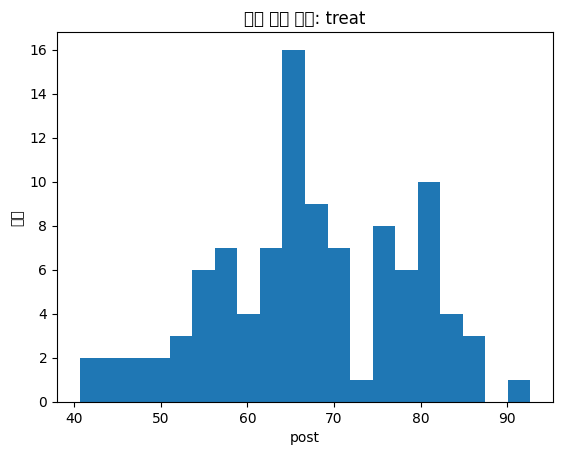

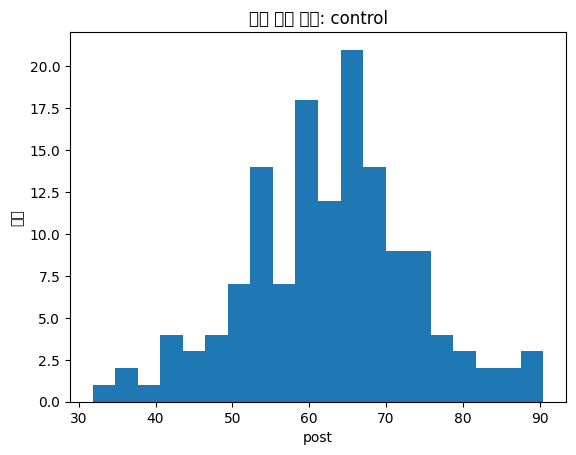

In [26]:

# 사후 점수(post) 분포를 집단별로 그려봅니다.
import matplotlib.pyplot as plt

for g in df_imp['group'].unique():
    x = df_imp.loc[df_imp['group']==g, 'post']
    plt.figure()
    plt.hist(x.dropna(), bins=20)  # 색상은 지정하지 않습니다.
    plt.title(f'사후 점수 분포: {g}')
    plt.xlabel('post')
    plt.ylabel('빈도')
    plt.show()


## 5. 가설 검정을 위한 기본 점검(정규성, 등분산성)

In [27]:

from scipy import stats

# 집단별 정규성 간단 점검(Shapiro-Wilk)
for g in df_imp['group'].unique():
    w, p = stats.shapiro(df_imp.loc[df_imp['group']==g, 'post'])
    print(g, 'Shapiro-Wilk W=', round(w,3), 'p=', round(p,3))

# 등분산성 점검(Levene)
control = df_imp.loc[df_imp['group']=='control', 'post']
treat   = df_imp.loc[df_imp['group']=='treat',   'post']
w_stat, p_levene = stats.levene(control, treat, center='median')
print('Levene W=', round(w_stat,3), 'p=', round(p_levene,3))


treat Shapiro-Wilk W= 0.984 p= 0.276
control Shapiro-Wilk W= 0.991 p= 0.553
Levene W= 0.191 p= 0.662


## 6. 가설 검정

In [28]:

# 6-1. 독립표본 t-검정: 두 집단의 사후 점수 평균 비교
from scipy import stats
tres = stats.ttest_ind(treat, control, equal_var=False, nan_policy='omit')
tres  # statistic, pvalue


TtestResult(statistic=3.1864681529572456, pvalue=0.0016565145024937263, df=213.02013368360764)

In [29]:

# 6-2. 대응 t-검정: 같은 사람이 pre와 post에서 얼마나 올랐는지 확인
paired = stats.ttest_rel(df_imp['post'], df_imp['pre'])
paired  # statistic, pvalue


TtestResult(statistic=11.263723224999694, pvalue=6.913962843830687e-24, df=239)

In [30]:

# 6-3. 카이제곱 검정: 합격률(passed)이 집단에 따라 다른가?
ct = pd.crosstab(df_imp['passed'], df_imp['group'])
chi2, p, dof, exp = stats.chi2_contingency(ct)
ct, (chi2, p, dof)


(group   control  treat
 passed                
 0           106     61
 1            34     39,
 (5.292335094976386, 0.021419480725166164, 1))

In [31]:

# 6-4. 일원분산분석(ANOVA): 성별에 따라 post 평균이 다른가?
F, p_anova = stats.f_oneway(*(df_imp.loc[df_imp['sex']==s, 'post'] for s in df_imp['sex'].unique()))
F, p_anova


(1.2534733668508478, 0.2640187181607438)

## 7. 회귀 분석(설명 변수 여러 개)

In [32]:

# OLS 회귀: post ~ group + pre + age + sex
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('post ~ C(group) + pre + age + C(sex)', data=df_imp).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   post   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     122.2
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           3.07e-56
Time:                        00:49:43   Log-Likelihood:                -789.95
No. Observations:                 240   AIC:                             1590.
Df Residuals:                     235   BIC:                             1607.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.9969      3.722      1.611      0.109      -1.337      13.330
C(group)[T.treat]     4.3568      0.861      5.058      0.000       2.660       6.054
C(sex)[T.M]           0.1041      0.853      0.122      0.903      -1.577       1.785
pre                   0.9772      0.046     21.292      0.000       0.887       1.068
age                  -0.0572      0.103     -0.557      0.578      -0.259       0.145
==============================================================================
Omnibus:                        7.047   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                8.218
Skew:                          -0.261   Prob(JB):                       0.0164
Kurtosis:                       3.742   Cond. No.                         578.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:

# 상호작용 고려: group*sex
model_int = smf.ols('post ~ C(group)*C(sex) + pre + age', data=df_imp).fit()
model_int.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   post   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     97.71
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           2.79e-55
Time:                        00:49:43   Log-Likelihood:                -789.68
No. Observations:                 240   AIC:                             1591.
Df Residuals:                     234   BIC:                             1612.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.3377      3.756      1.688      0.093      -1.061      13.737
C(group)[T.treat]                 3.7596      1.192      3.155      0.002       1.412       6.107
C(sex)[T.M]                      -0.4204      1.119     -0.376      0.707      -2.624       1.784
C(group)[T.treat]:C(sex)[T.M]     1.2540      1.727      0.726      0.469      -2.149       4.657
pre                               0.9755      0.046     21.211      0.000       0.885       1.066
age                              -0.0568      0.103     -0.553      0.581      -0.259       0.146
==============================================================================
Omnibus:                        7.346   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                8.657
Skew:                          -0.268   Prob(JB):                       0.0132
Kurtosis:                       3.761   Cond. No.                         585.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:

# 로지스틱 회귀: 합격 여부(passed) ~ group + pre + age + sex
logit = smf.logit('passed ~ C(group) + pre + age + C(sex)', data=df_imp).fit(disp=False)
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 passed   No. Observations:                  240
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.4893
Time:                        00:49:43   Log-Likelihood:                -75.299
converged:                       True   LL-Null:                       -147.44
Covariance Type:            nonrobust   LLR p-value:                 3.401e-30
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -19.5347      3.001     -6.509      0.000     -25.417     -13.653
C(group)[T.treat]     1.2595      0.434      2.902      0.004       0.409       2.110
C(sex)[T.M]          -0.2473      0.420     -0.590      0.556      -1.070       0.575
pre                   0.3098      0.043      7.261      0.000       0.226       0.393
age                  -0.0439      0.046     -0.950      0.342      -0.134       0.047
=====================================================================================
"""

## 8. 효과크기(effect size) 계산

In [35]:

# Cohen's d: 두 집단 평균 차이의 크기(표준편차 단위)
def cohens_d(x, y):
    x = pd.Series(x).dropna()
    y = pd.Series(y).dropna()
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / s_pooled

d = cohens_d(df_imp.loc[df_imp['group']=='treat','post'],
             df_imp.loc[df_imp['group']=='control','post'])
d


0.41741039737006597

## 9. 검정력(power) 계산

In [36]:

from statsmodels.stats.power import TTestIndPower
analysis = TTestIndPower()
effect = abs(d)
n1 = (df_imp['group']=='treat').sum()
ratio = (df_imp['group']=='control').sum() / n1
power = analysis.power(effect_size=effect, nobs1=n1, ratio=ratio, alpha=0.05, alternative='two-sided')
effect, power


(0.41741039737006597, 0.8878495496607457)

## 10. 진단 플롯

C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\avfrd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 440

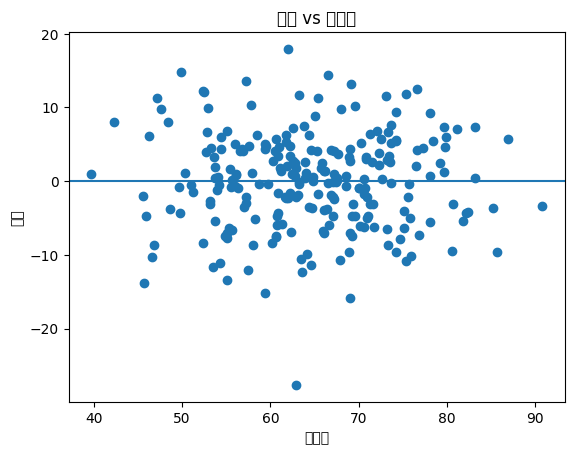

ShapiroResult(statistic=0.9910700180035593, pvalue=0.15004798883885612)

In [37]:

# 잔차가 고르게 퍼졌는지 확인(선형회귀 기본 가정 점검)
import matplotlib.pyplot as plt
resid = model.resid
fitted = model.fittedvalues

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0)
plt.title('잔차 vs 적합값')
plt.xlabel('적합값'); plt.ylabel('잔차')
plt.show()

# 잔차의 정규성(Shapiro-Wilk)
from scipy.stats import shapiro
shapiro(resid)


## 11. 비모수 대안

In [38]:

# 정규성 가정이 약할 때 사용하는 방법
from scipy import stats
stats.mannwhitneyu(control, treat, alternative='two-sided')


MannwhitneyuResult(statistic=5379.5, pvalue=0.0022486646246008893)

## 12. 결과표 만들기 및 저장

In [39]:

# 표1: 집단별(age, pre, post) 요약 통계
table1 = df_imp.groupby('group')[['age','pre','post']].agg(['count','mean','std']).round(2)
table1


age                pre               post              
        count   mean   std count   mean   std count   mean    std
group                                                            
control   140  26.24  4.14   140  59.47  8.94   140  62.66  11.21
treat     100  26.50  4.22   100  59.82  9.95   100  67.35  11.25

In [40]:

# 표2: OLS 회귀 계수표
ols_tbl = model.summary2().tables[1]
ols_tbl


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.996931,3.722400,1.611039,1.085135e-01,-1.336606,13.330468
C(group)[T.treat],4.356754,0.861275,5.058496,8.515286e-07,2.659948,6.053560
C(sex)[T.M],0.104133,0.853371,0.122025,9.029833e-01,-1.577102,1.785368
pre,0.977161,0.045893,21.292227,9.181279e-57,0.886747,1.067575
age,-0.057173,0.102580,-0.557345,5.778223e-01,-0.259267,0.144922


In [43]:

# CSV로 저장해서 논문/보고서에 붙이기 좋게 만듭니다.
table1_path = "table1_descriptives_ko.csv"
ols_path    = "table2_ols_coefs_ko.csv"
table1.to_csv(table1_path)
ols_tbl.to_csv(ols_path)
(table1_path, ols_path)


('table1_descriptives_ko.csv', 'table2_ols_coefs_ko.csv')

## 13. 마무리 정리 글감


- 결과 요약: 처치 집단의 사후 점수가 통제 집단보다 유의하게 높은지 확인.  
- 해석: 효과크기 d 값과 신뢰구간을 함께 보고 실질적 차이를 설명.  
- 한계: 표본 추출 방법, 결측치 대체, 측정 도구 신뢰도 등.  
- 제언: 더 큰 표본, 다양한 집단, 장기 추적 연구.
